In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv('train_file.csv')
test_df = pd.read_csv('test_file.csv')
train_df.head()

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv
0,1,Male,Urban,Bachelor,5L-10L,1,5,5790,More than 1,A,Platinum,64308
1,2,Male,Rural,High School,5L-10L,0,8,5080,More than 1,A,Platinum,515400
2,3,Male,Urban,Bachelor,5L-10L,1,8,2599,More than 1,A,Platinum,64212
3,4,Female,Rural,High School,5L-10L,0,7,0,More than 1,A,Platinum,97920
4,5,Male,Urban,High School,More than 10L,1,6,3508,More than 1,A,Gold,59736


## feature engineering

In [87]:
train_df.head()

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv
0,1,Male,Urban,Bachelor,5L-10L,1,5,5790,More than 1,A,Platinum,64308
1,2,Male,Rural,High School,5L-10L,0,8,5080,More than 1,A,Platinum,515400
2,3,Male,Urban,Bachelor,5L-10L,1,8,2599,More than 1,A,Platinum,64212
3,4,Female,Rural,High School,5L-10L,0,7,0,More than 1,A,Platinum,97920
4,5,Male,Urban,High School,More than 10L,1,6,3508,More than 1,A,Gold,59736


In [88]:
train_df['gen_area'] = train_df['gender']+'_'+ train_df['area']
train_df.head()

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv,gen_area
0,1,Male,Urban,Bachelor,5L-10L,1,5,5790,More than 1,A,Platinum,64308,Male_Urban
1,2,Male,Rural,High School,5L-10L,0,8,5080,More than 1,A,Platinum,515400,Male_Rural
2,3,Male,Urban,Bachelor,5L-10L,1,8,2599,More than 1,A,Platinum,64212,Male_Urban
3,4,Female,Rural,High School,5L-10L,0,7,0,More than 1,A,Platinum,97920,Female_Rural
4,5,Male,Urban,High School,More than 10L,1,6,3508,More than 1,A,Gold,59736,Male_Urban


In [89]:
train_df['policy_pol_type'] = train_df['type_of_policy'] + '_' + train_df['policy']

In [90]:
train_df['qualification_with_policies'] = train_df['qualification'] + '_' + train_df['num_policies']

In [91]:
train_df['income_marital_status'] = train_df['income'] + '_' +train_df['marital_status'].astype('str')

In [92]:
new_train_df = train_df.drop(columns=['id','gender','area','qualification','num_policies','policy','type_of_policy','income','marital_status'],axis=1)

In [93]:
#lets define a function to do feature engineering
def handle_cat(train_df):
    train_df['gen_area'] = train_df['gender']+'_'+ train_df['area']
    train_df['policy_pol_type'] = train_df['type_of_policy'] + '_' + train_df['policy']
    train_df['qualification_with_policies'] = train_df['qualification'] + '_' + train_df['num_policies']
    train_df['income_marital_status'] = train_df['income'] + '_' +train_df['marital_status'].astype('str')
    new_train_df = train_df.drop(columns=['id','gender','area','qualification','num_policies','policy','type_of_policy','income','marital_status'],axis=1) 
    return new_train_df

In [94]:
new_train_df.head()

,vintage,claim_amount,cltv,gen_area,policy_pol_type,qualification_with_policies,income_marital_status
0,5,5790,64308,Male_Urban,Platinum_A,Bachelor_More than 1,5L-10L_1
1,8,5080,515400,Male_Rural,Platinum_A,High School_More than 1,5L-10L_0
2,8,2599,64212,Male_Urban,Platinum_A,Bachelor_More than 1,5L-10L_1
3,7,0,97920,Female_Rural,Platinum_A,High School_More than 1,5L-10L_0
4,6,3508,59736,Male_Urban,Gold_A,High School_More than 1,More than 10L_1


In [95]:
import category_encoders as ce

C:\Users\theas\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[]

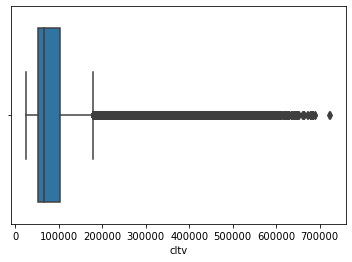

In [96]:
#checking outliers
sns.boxplot(new_train_df['cltv'])
plt.plot()

In [97]:
#removing outliers
quantile = new_train_df['cltv'].quantile(0.99)
quantile

485520.0

In [98]:
print(f"min - {new_train_df['cltv'].min()}")
print(f"max - {new_train_df['cltv'].max()}")

min - 24828
max - 724068


In [99]:
new_train_df[new_train_df['cltv'] > quantile] = quantile

In [100]:
print(f"min - {new_train_df['cltv'].min()}")
print(f"max - {new_train_df['cltv'].max()}")

min - 24828
max - 485520


In [101]:
from sklearn.model_selection import train_test_split
X = new_train_df.drop('cltv',axis=1)
Y = new_train_df['cltv']
xtrain ,xtest ,ytrain,ytest = train_test_split(X,Y , test_size=0.33 , random_state=1)

In [102]:
# Define catboost encoder
cbe_encoder = ce.cat_boost.CatBoostEncoder()
  
# Fit encoder and transform the features
cbe_encoder.fit(xtrain, ytrain)
train_cbe = cbe_encoder.transform(xtrain)

In [103]:
test_cbe = cbe_encoder.transform(xtest)

In [104]:
from sklearn.tree import DecisionTreeRegressor
# Fit regression model
regr = DecisionTreeRegressor(max_depth=5)
regr.fit(train_cbe, ytrain)
test_pred=regr.predict(test_cbe)
train_pred = regr.predict(train_cbe)

In [105]:
# r2_score
from sklearn.metrics import r2_score
print(f'test r2_score = {r2_score(ytest, test_pred)}')
print(f'train r2_score = {r2_score(ytrain, train_pred)}')

test r2_score = 0.3153263920759456
train r2_score = 0.3372099601518278


In [106]:
#final predictions for submission
final_df = handle_cat(test_df)

In [107]:
final_df.head()

,vintage,claim_amount,gen_area,policy_pol_type,qualification_with_policies,income_marital_status
0,6,2134,Female_Rural,Silver_B,High School_More than 1,5L-10L_0
1,4,4102,Female_Urban,Platinum_A,High School_More than 1,2L-5L_0
2,7,2925,Male_Rural,Gold_B,High School_More than 1,5L-10L_1
3,2,0,Female_Rural,Silver_B,Bachelor_More than 1,More than 10L_1
4,5,14059,Female_Urban,Silver_B,High School_More than 1,2L-5L_0


In [108]:
#encoding categorical features
final_df=cbe_encoder.transform(final_df)

In [109]:
final_pred=regr.predict(final_df)

In [110]:
final_id = test_df.id

In [111]:
submission_df = pd.DataFrame({'id':final_id , 'cltv':final_pred})

In [112]:
submission_df.head()

,id,cltv
0,89393,90490.429700
1,89394,112471.403346
2,89395,90490.429700
3,89396,90490.429700
4,89397,124222.938712


In [115]:
submission_df.to_csv('submission_csv.csv',index=False)

# --------------------------------------------

In [118]:
diff= pd.DataFrame({'true': ytest, 'predicted':test_pred})

In [176]:
diff['diff'] =   diff['true'] - diff['predicted']
print(f"min - {diff['diff'].min()}")
print(f"max - {diff['diff'].max()}")

min - -110987.35614496862
max - 400820.40408061707


In [177]:
#lets built model to predict error
error_tree = DecisionTreeRegressor(max_depth=3)
train_error =  ytrain - train_pred


error_tree.fit(train_cbe,train_error)

DecisionTreeRegressor(max_depth=3)

In [178]:
print(f'train error r2_score = {r2_score(train_error, error_tree.predict(train_cbe))}')

train error r2_score = 0.003272623721742085


In [179]:
test_error = error_tree.predict(test_cbe)
test_error

array([ 2338.13507045,  -949.40081478,  -949.40081478, ...,
       -5393.44345621,  6896.23600419, -5393.44345621])

In [188]:
print(f' test error r2_score = {r2_score(diff["diff"], test_error) } ')

 test error r2_score = 0.0036376823708400563 


In [189]:
test_final = test_pred - (abs(test_error))

In [190]:
print(f'test r2_score = {r2_score(ytest, test_final)}')

test r2_score = 0.31242616569383197


In [183]:
test_error

array([ 2338.13507045,  -949.40081478,  -949.40081478, ...,
       -5393.44345621,  6896.23600419, -5393.44345621])

In [184]:
-test_error

array([-2338.13507045,   949.40081478,   949.40081478, ...,
        5393.44345621, -6896.23600419,  5393.44345621])

In [185]:
diff['final']= test_final

In [186]:
diff['error_pred'] = test_error

In [187]:
diff

,true,predicted,diff,final,error_pred
8414,66240,47906.083072,18333.916928,50244.218143,2338.135070
42736,54960,47906.083072,7053.916928,46956.682257,-949.400815
29542,34644,47906.083072,-13262.083072,46956.682257,-949.400815
70328,34392,50763.595919,-16371.595919,49814.195105,-949.400815
65963,67836,124059.398844,-56223.398844,130955.634848,6896.236004
...,...,...,...,...,...
22921,29184,50763.595919,-21579.595919,49814.195105,-949.400815
52735,49872,124059.398844,-74187.398844,124629.563772,570.164928
49475,68748,139019.356145,-70271.356145,133625.912689,-5393.443456
86339,110280,124059.398844,-13779.398844,130955.634848,6896.236004


In [191]:
from sklearn.ensemble import RandomForestRegressor

In [221]:
 # create regressor object
rf = RandomForestRegressor(
 ccp_alpha= 0.1,
 criterion= 'mse',
 max_depth= 3,
 max_features= 'sqrt',
 max_leaf_nodes= 4,
 max_samples= None,
 min_impurity_split= 0.0,
 min_samples_leaf= 1,
 min_samples_split= 3,
 min_weight_fraction_leaf= 0.0,
 n_estimators= 100,
 n_jobs= -1,
 oob_score= False,
 random_state= 1,
 verbose= 1,
 warm_start= False)

In [222]:
rf.fit(train_cbe, ytrain)
rf_test_pred=regr.predict(test_cbe)
rf_train_pred = regr.predict(train_cbe)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
C:\Users\theas\anaconda3\lib\site-packages\sklearn\tree\_classes.py:316: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
C:\Users\theas\anaconda3\lib\site-packages\sklearn\tree\_classes.py:316: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
C:\Users\theas\anaconda3\lib\site-packages\sklearn\tree\_classes.py:316: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter ins

C:\Users\theas\anaconda3\lib\site-packages\sklearn\tree\_classes.py:316: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
C:\Users\theas\anaconda3\lib\site-packages\sklearn\tree\_classes.py:316: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
C:\Users\theas\anaconda3\lib\site-packages\sklearn\tree\_classes.py:316: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
C:\Users\theas\anaconda3\lib\site-packages\sklearn\tree\_c

In [223]:
# r2_score
from sklearn.metrics import r2_score
print(f'test r2_score = {r2_score(ytest, rf_test_pred)}')
print(f'train r2_score = {r2_score(ytrain, rf_train_pred)}')

test r2_score = 0.3153263920759456
train r2_score = 0.3372099601518278


In [202]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

# ----------------------------

# linear regression

In [224]:
from sklearn.linear_model import LinearRegression

In [226]:
lr = LinearRegression(n_jobs = -1)
lr.fit(train_cbe, ytrain)
lr_test_pred=lr.predict(test_cbe)
lr_train_pred = lr.predict(train_cbe)

In [227]:
print(f'test r2_score = {r2_score(ytest, lr_test_pred)}')
print(f'train r2_score = {r2_score(ytrain, lr_train_pred)}')

test r2_score = 0.31275174982913345
train r2_score = 0.3347358388295688


In [228]:
from sklearn.preprocessing import MinMaxScaler
mc = MinMaxScaler().fit(train_cbe)
mc_xtest = mc.transform(test_cbe)
mc_train = mc.transform(train_cbe)

array([[8.23858955e-06, 0.00000000e+00, 1.39309483e-02, 5.10992404e-02,
        6.49120539e-03, 1.29101066e-02],
       [1.02982369e-05, 0.00000000e+00, 0.00000000e+00, 1.99836858e-02,
        6.49120539e-03, 1.29101066e-02],
       [2.05964739e-06, 0.00000000e+00, 1.39309483e-02, 3.75786985e-02,
        9.03118683e-03, 1.29101066e-02],
       ...,
       [1.02982369e-05, 2.17004449e-02, 5.95861915e-02, 3.98154933e-02,
        1.48703897e-01, 1.29101066e-02],
       [1.23578843e-05, 1.14495798e-02, 6.18949820e-02, 3.75786985e-02,
        1.48703897e-01, 7.10813191e-02],
       [8.23858955e-06, 4.86488713e-03, 0.00000000e+00, 3.98154933e-02,
        1.48703897e-01, 1.29101066e-02]])

In [230]:
lr.fit(mc_train, ytrain)
lr_test_pred=lr.predict(mc_xtest)
lr_train_pred = lr.predict(mc_train)

In [231]:
print(f'test r2_score = {r2_score(ytest, lr_test_pred)}')
print(f'train r2_score = {r2_score(ytrain, lr_train_pred)}')

test r2_score = 0.31275174982913345
train r2_score = 0.3347358388295688


# xgboost

In [232]:
import xgboost as xg

In [233]:
from sklearn.metrics import mean_squared_error as MSE

In [245]:
# Instantiation
xgb_r = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123)

In [ ]:
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE
# Instantiation
xgb_r = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123)
# Fitting the model
xgb_r.fit(mc_train, ytrain)

In [246]:
# Fitting the model
xgb_r.fit(mc_train, ytrain)

[22:05:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=8, num_parallel_tree=1,
             objective='reg:linear', random_state=123, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=123, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [247]:
xg_test_pred=xgb_r.predict(mc_xtest)
xg_train_pred = xgb_r.predict(mc_train)

In [248]:
print(f'test r2_score = {r2_score(ytest, xg_test_pred)}')
print(f'train r2_score = {r2_score(ytrain, xg_train_pred)}')

test r2_score = 0.31814683813502864
train r2_score = 0.3461409364406419


In [249]:
train_dmatrix = xg.DMatrix(data = mc_train, label = ytrain)
test_dmatrix = xg.DMatrix(data = mc_xtest, label = ytest)

In [251]:
# Parameter dictionary specifying base learner
param = {"booster":"gblinear", "objective":"reg:squarederror"}
  
xgb_r = xg.train(params = param, dtrain = train_dmatrix, num_boost_round = 10)
pred = xgb_r.predict(train_dmatrix)

In [252]:
print(f'train r2_score = {r2_score(ytrain, pred)}')

train r2_score = -365.7561895347826


In [ ]:
xg_test_pred=xgb_r.predict(mc_xtest)
xg_train_pred = xgb_r.predict(mc_train)

# TPOTC

In [254]:
#pip install TPOT

In [255]:
from tpot import TPOTRegressor

In [256]:
pipeline_optimizer = TPOTRegressor(generations=5, population_size=20, cv=5,random_state=42, verbosity=2)

In [257]:
pipeline_optimizer.fit(train_cbe, ytrain)

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -5142095422.32042

Generation 2 - Current best internal CV score: -5142095422.32042

Generation 3 - Current best internal CV score: -5142095422.32042

Generation 4 - Current best internal CV score: -5142095422.32042

Generation 5 - Current best internal CV score: -5140771611.13953

Best pipeline: DecisionTreeRegressor(RidgeCV(input_matrix), max_depth=6, min_samples_leaf=17, min_samples_split=5)


TPOTRegressor(generations=5, population_size=20, random_state=42, verbosity=2)

In [259]:
print(pipeline_optimizer.score(test_cbe,ytest))

-5238407866.574848


In [260]:
pipeline_optimizer.export('tpot_exported_pipeline.py')

In [ ]:
max_depth=6, min_samples_leaf=17, min_samples_split=5

In [261]:
from sklearn.tree import DecisionTreeRegressor
# Fit regression model
regr = DecisionTreeRegressor(max_depth=6, min_samples_leaf=17, min_samples_split=5)
regr.fit(train_cbe, ytrain)
test_pred=regr.predict(test_cbe)
train_pred = regr.predict(train_cbe)

In [262]:
# r2_score
from sklearn.metrics import r2_score
print(f'test r2_score = {r2_score(ytest, test_pred)}')
print(f'train r2_score = {r2_score(ytrain, train_pred)}')

test r2_score = 0.31697353750613166
train r2_score = 0.33934479461255995


In [263]:
final_pred=regr.predict(final_df)

In [264]:
submission_df_1 = pd.DataFrame({'id':final_id , 'cltv':final_pred})

In [265]:
submission_df_1

,id,cltv
0,89393,92665.512605
1,89394,116121.891286
2,89395,88011.447887
3,89396,88011.447887
4,89397,126032.974003
...,...,...
59590,148983,47166.775064
59591,148984,49061.066265
59592,148985,108372.815029
59593,148986,103056.436860


In [267]:
submission_df_1.to_csv('2nd_submission.csv',index=False)

# 3rd

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv('train_file.csv')
test_df = pd.read_csv('test_file.csv')
train_df.head()

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv
0,1,Male,Urban,Bachelor,5L-10L,1,5,5790,More than 1,A,Platinum,64308
1,2,Male,Rural,High School,5L-10L,0,8,5080,More than 1,A,Platinum,515400
2,3,Male,Urban,Bachelor,5L-10L,1,8,2599,More than 1,A,Platinum,64212
3,4,Female,Rural,High School,5L-10L,0,7,0,More than 1,A,Platinum,97920
4,5,Male,Urban,High School,More than 10L,1,6,3508,More than 1,A,Gold,59736


In [47]:
def handle_cat(train_df):
    train_df['gen_area'] = train_df['gender']+'_'+ train_df['area'] + '_'+ train_df['qualification']
    train_df['policy_pol_type'] = train_df['type_of_policy'] + '_' + train_df['policy'] + '_' + train_df['num_policies']
    #train_df['qualification_with_policies'] = train_df['qualification'] + '_' + train_df['num_policies']
    train_df['income_marital_status'] = train_df['income'] + '_' +train_df['marital_status'].astype('str')
    new_train_df = train_df.drop(columns=['id','gender','area','qualification','num_policies','policy','type_of_policy','income','marital_status'],axis=1) 
    return new_train_df

In [48]:
#encoding categorical features
#final_df=cbe_encoder.transform(final_df)

In [69]:
#lets handle outliers in claim_amount
print(train_df.claim_amount.max())
print(train_df.claim_amount.min())
print(train_df.claim_amount.quantile(0.99))
print(train_df.claim_amount.quantile(0.02))


31894
0
14868.089999999997
0.0


In [78]:
print(train_df.claim_amount.quantile(0.02))
print(train_df.claim_amount.quantile(0.05))
print(train_df.claim_amount.quantile(0.20))

0.0
0.0
2017.0


In [49]:

from sklearn.model_selection import train_test_split
new_train_df = handle_cat(train_df)
# Define catboost encoder
import category_encoders as ce

cbe_encoder = ce.cat_boost.CatBoostEncoder()

#removing outliers
quantile = new_train_df['cltv'].quantile(0.99)
new_train_df[new_train_df['cltv'] > quantile] = quantile
upper_claim = new_train_df['claim_amount'].quantile(0.99)
new_train_df[new_train_df['claim_amount'] > upper_quantile] = upper_quantile


#lets handle outliers in claim_amount
X = new_train_df.drop('cltv',axis=1)
Y = new_train_df['cltv']
xtrain ,xtest ,ytrain,ytest = train_test_split(X,Y , test_size=0.33 , random_state=2) #1

In [50]:
# Define catboost encoder
cbe_encoder = ce.cat_boost.CatBoostEncoder()
  
# Fit encoder and transform the features
cbe_encoder.fit(xtrain, ytrain)
train_cbe = cbe_encoder.transform(xtrain)
test_cbe = cbe_encoder.transform(xtest)

In [51]:
train_cbe

,vintage,claim_amount,gen_area,policy_pol_type,income_marital_status
64087,6,0,79061.956299,103823.828623,97067.787368
2131,8,0,75330.475398,119123.902285,86438.527928
37945,6,3734,99969.047006,117114.839921,97067.787368
50619,6,5755,100960.530385,127020.914492,110133.183918
16504,8,4768,99969.047006,49118.355139,110133.183918
...,...,...,...,...,...
84434,8,4368,102650.416401,117114.839921,97067.787368
31019,6,0,102650.416401,117114.839921,86438.527928
44566,6,8856,100960.530385,117114.839921,97067.787368
72173,7,5090,102650.416401,49118.355139,97067.787368


In [52]:
from sklearn.tree import DecisionTreeRegressor
# Fit regression model
regr = DecisionTreeRegressor(max_depth=6, min_samples_leaf=17, min_samples_split=5)
regr.fit(train_cbe, ytrain)
test_pred=regr.predict(test_cbe)
train_pred = regr.predict(train_cbe)

In [53]:
# r2_score
from sklearn.metrics import r2_score
print(f'test r2_score = {r2_score(ytest, test_pred)}')
print(f'train r2_score = {r2_score(ytrain, train_pred)}')

test r2_score = 0.31949729320200715
train r2_score = 0.338864334019923


In [54]:
#final predictions for submission
final_df = handle_cat(test_df)

In [55]:
final_df_encode = cbe_encoder.transform(final_df)

In [56]:
final_pred=regr.predict(final_df_encode)

In [57]:
submission_df_2 = pd.DataFrame({'id':test_df.id , 'cltv':final_pred})

In [58]:
submission_df_2

,id,cltv
0,89393,94358.728998
1,89394,115873.426432
2,89395,94358.728998
3,89396,88181.150977
4,89397,129307.988950
...,...,...
59590,148983,46899.868132
59591,148984,48353.985838
59592,148985,115873.426432
59593,148986,108672.646088


In [39]:
submission_df_2.to_csv('2nd_day_2nd_submission.csv',index=False)

### lets check after changing lower quantile

In [144]:
from sklearn.model_selection import train_test_split
new_train_df = handle_cat(train_df)
# Define catboost encoder
import category_encoders as ce

cbe_encoder = ce.cat_boost.CatBoostEncoder()

#removing outliers
quantile = new_train_df['cltv'].quantile(0.99)
low_quantile = new_train_df['cltv'].quantile(0.005)
new_train_df['cltv']=np.where(new_train_df['cltv'] > quantile ,quantile , new_train_df['cltv'])
new_train_df['cltv']=np.where(new_train_df['cltv'] < low_quantile ,low_quantile , new_train_df['cltv'])
upper_claim = new_train_df['claim_amount'].quantile(0.99)
new_train_df['claim_amount']=np.where(new_train_df['claim_amount'] > upper_claim, upper_claim,new_train_df['claim_amount'])
#new_train_df[new_train_df['cltv'] > quantile] = quantile
#new_train_df[new_train_df['cltv'] < low_quantile] = low_quantile
X = new_train_df.drop('cltv',axis=1)
Y = new_train_df['cltv']
xtrain ,xtest ,ytrain,ytest = train_test_split(X,Y , test_size=0.33 , random_state=1) #1

In [145]:
# Define catboost encoder
cbe_encoder = ce.cat_boost.CatBoostEncoder()
  
# Fit encoder and transform the features
cbe_encoder.fit(xtrain, ytrain)
train_cbe = cbe_encoder.transform(xtrain)
test_cbe = cbe_encoder.transform(xtest)

In [146]:
from sklearn.tree import DecisionTreeRegressor
# Fit regression model
regr = DecisionTreeRegressor(max_depth=6, min_samples_leaf=17, min_samples_split=5)
regr.fit(train_cbe, ytrain)
test_pred=regr.predict(test_cbe)
train_pred = regr.predict(train_cbe)

In [147]:
# r2_score
from sklearn.metrics import r2_score
print(f'test r2_score = {r2_score(ytest, test_pred)}')
print(f'train r2_score = {r2_score(ytrain, train_pred)}')

test r2_score = 0.16769400241084187
train r2_score = 0.1646218134798776


In [148]:
#final predictions for submission
final_df = handle_cat(test_df)
b = cbe_encoder.transform(final_df)
final_pred=regr.predict(final_df_encode)
submission_df_2 = pd.DataFrame({'id':test_df.id , 'cltv':final_pred})
submission_df_2

,id,cltv
0,89393,88699.880593
1,89394,122935.143653
2,89395,97415.647612
3,89396,88699.880593
4,89397,115034.281690
...,...,...
59590,148983,48396.953397
59591,148984,45168.346515
59592,148985,122935.143653
59593,148986,97415.647612


In [149]:
final_df_encode

,vintage,claim_amount,gen_area,policy_pol_type,income_marital_status
0,6,2134,81795.575703,102951.517422,101797.844565
1,4,4102,105291.131296,123540.367182,116802.190611
2,7,2925,77301.410411,108554.453981,89335.011555
3,2,0,85727.076498,102951.517422,83256.385671
4,5,14059,105291.131296,102951.517422,116802.190611
...,...,...,...,...,...
59590,6,0,77324.320739,49911.177429,89335.011555
59591,6,0,106758.770280,54120.607695,101797.844565
59592,4,3323,105291.131296,108222.785235,102457.058223
59593,1,2886,77324.320739,123113.847962,101797.844565


In [150]:
submission_df_2.to_csv('2nd_day_5th_submission.csv',index=False)

# ----------- DT with different random states

In [170]:
train_df = pd.read_csv('train_file.csv')
test_df = pd.read_csv('test_file.csv')
train_df.head()

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv
0,1,Male,Urban,Bachelor,5L-10L,1,5,5790,More than 1,A,Platinum,64308
1,2,Male,Rural,High School,5L-10L,0,8,5080,More than 1,A,Platinum,515400
2,3,Male,Urban,Bachelor,5L-10L,1,8,2599,More than 1,A,Platinum,64212
3,4,Female,Rural,High School,5L-10L,0,7,0,More than 1,A,Platinum,97920
4,5,Male,Urban,High School,More than 10L,1,6,3508,More than 1,A,Gold,59736


In [4]:
def handle_cat(train_df):
    train_df['gen_area'] = train_df['gender']+ train_df['area'] + train_df['qualification']
    train_df['gen_married'] =  train_df['gender'] + train_df['marital_status'].astype('str')
    train_df['income_marital_status'] = train_df['income']  + train_df['marital_status'].astype('str')
    train_df['policy_pol_type'] = train_df['type_of_policy'] + train_df['policy'] + train_df['num_policies']
#     train_df['merried_income'] = train_df['income'] + train_df['marital_status'].astype('str')
    train_df['vintage'] =  train_df['vintage'].astype('str') + train_df['gender']
    
#     train_df['qualification_with_policies'] =   + train_df['num_policies']
    new_train_df = train_df.drop(columns=['id'],axis=1)
#     new_train_df = train_df.drop(columns=['id','gender','area','qualification','num_policies','policy','type_of_policy','income','marital_status','vintage'],axis=1) 
    return new_train_df

In [210]:
# random_state = []
# test = []
# train = []
# for i in range(200):
from sklearn.model_selection import train_test_split
new_train_df = handle_cat(train_df)
# Define catboost encoder
import category_encoders as ce

cbe_encoder = ce.cat_boost.CatBoostEncoder()

#removing outliers
quantile = new_train_df['cltv'].quantile(0.99)
low_quantile = new_train_df['cltv'].quantile(0.005)
new_train_df['cltv']=np.where(new_train_df['cltv'] > quantile ,quantile , new_train_df['cltv'])
new_train_df['cltv']=np.where(new_train_df['cltv'] < low_quantile ,low_quantile , new_train_df['cltv'])
upper_claim = new_train_df['claim_amount'].quantile(0.99)
new_train_df['claim_amount']=np.where(new_train_df['claim_amount'] > upper_claim, upper_claim,new_train_df['claim_amount'])
lower_claim = new_train_df['claim_amount'].quantile(0.2)
new_train_df['claim_amount']=np.where(new_train_df['claim_amount'] < lower_claim, lower_claim,new_train_df['claim_amount'])
#new_train_df[new_train_df['cltv'] > quantile] = quantile
#new_train_df[new_train_df['cltv'] < low_quantile] = low_quantile
X = new_train_df.drop('cltv',axis=1)
Y = new_train_df['cltv']
xtrain ,xtest ,ytrain,ytest = train_test_split(X,Y , test_size=0.4 , random_state=1)

# Define catboost encoder
cbe_encoder = ce.cat_boost.CatBoostEncoder(sigma=1,a=13)

# Fit encoder and transform the features
cbe_encoder.fit(xtrain, ytrain)
train_cbe = cbe_encoder.transform(xtrain)
test_cbe = cbe_encoder.transform(xtest)

from sklearn.tree import DecisionTreeRegressor
# Fit regression model
dtr = DecisionTreeRegressor(max_depth=6, min_samples_leaf=17, min_samples_split=5)
dtr.fit(train_cbe, ytrain)
test_pred=dtr.predict(test_cbe)
train_pred = dtr.predict(train_cbe)

# r2_score


from sklearn.metrics import r2_score
# print(f' For {i}')
print(f'test r2_score = {r2_score(ytest, test_pred)}')
print(f'train r2_score = {r2_score(ytrain, train_pred)}')
#     random_state.append(i)
#     test.append(r2_score(ytest, test_pred))
#     train.append(r2_score(ytrain, train_pred))
# dt = pd.DataFrame({"random_state":random_state ,'test':test ,"train":train})
    

#     mapping[i]=(r2_score(ytest, test_pred) , r2_score(ytrain, train_pred))

test r2_score = 0.16076564217901623
train r2_score = 0.16879615580623897


In [190]:
test_cbe

,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,gen_area,gen_married,income_marital_status,policy_pol_type
8414,97694.080916,79400.221980,98738.594255,94188.877185,1,98641.597517,2017.0,51152.660981,106618.372172,99317.315239,81550.276900,91640.335268,89157.256843,54019.457110
42736,97258.723082,79400.221980,98738.594255,94188.877185,1,92153.611009,2017.0,51152.660981,88992.557093,99317.315239,77173.168481,91597.475683,89157.256843,50249.996223
29542,97694.080916,79400.221980,97849.275059,94188.877185,1,93174.447019,2017.0,51152.660981,99813.945281,98557.470957,85008.210668,91640.335268,89157.256843,50961.659868
70328,97258.723082,105164.313019,97849.275059,89606.613894,1,105847.999531,3717.0,51152.660981,88992.557093,99317.315239,104937.234921,91597.475683,83297.372469,50249.996223
65963,97694.080916,105164.313019,98738.594255,109508.971326,0,101950.672541,6825.0,119728.983044,99813.945281,99317.315239,104714.441271,104619.458786,117200.919271,123323.348104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64662,97258.723082,79400.221980,97849.275059,89606.613894,1,90744.831871,2017.0,51152.660981,88992.557093,99317.315239,77609.670851,91597.475683,83297.372469,50249.996223
44567,97258.723082,79400.221980,98738.594255,94188.877185,1,90744.831871,3060.0,119728.983044,88992.557093,99317.315239,77173.168481,91597.475683,89157.256843,107709.635344
49139,97694.080916,105164.313019,98738.594255,109508.971326,1,98506.676073,7845.0,119728.983044,106618.372172,99317.315239,104714.441271,91640.335268,102633.885827,135340.457785
643,97258.723082,105164.313019,98738.594255,109508.971326,0,98415.777805,2740.0,119728.983044,88992.557093,92083.513554,107099.668669,105897.355084,117200.919271,102692.780678


In [126]:
dt

,random_state,test,train
0,0,0.161950,0.166868
1,1,0.163165,0.167317
2,2,0.159970,0.168188
3,3,0.160716,0.167882
4,4,0.161612,0.166999
...,...,...,...
195,195,0.164289,0.166984
196,196,0.158519,0.167765
197,197,0.159693,0.168367
198,198,0.165978,0.164971


In [127]:
dt.test.max()

0.1686266767511012

In [143]:
dt[dt.test >= 0.165]

,random_state,test,train
11,11,0.165784,0.165138
62,62,0.166642,0.164369
84,84,0.167347,0.163955
87,87,0.166142,0.165075
141,141,0.167694,0.164622
189,189,0.168627,0.164201
198,198,0.165978,0.164971


In [153]:
dt.test.max()

0.16755105348440735

In [154]:
dt[dt.test >= 0.165]

,random_state,test,train
62,62,0.165818,0.166370
84,84,0.166700,0.165648
141,141,0.165593,0.166353
189,189,0.167551,0.166210


In [183]:
final_df = handle_cat(test_df)
final_df

,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,gen_area,gen_married,income_marital_status,policy_pol_type
0,Female,Rural,High School,5L-10L,0,6FemaleFemale,2134,More than 1,B,Silver,FemaleRuralHigh School,Female0,5L-10L0,SilverBMore than 1
1,Female,Urban,High School,2L-5L,0,4FemaleFemale,4102,More than 1,A,Platinum,FemaleUrbanHigh School,Female0,2L-5L0,PlatinumAMore than 1
2,Male,Rural,High School,5L-10L,1,7MaleMale,2925,More than 1,B,Gold,MaleRuralHigh School,Male1,5L-10L1,GoldBMore than 1
3,Female,Rural,Bachelor,More than 10L,1,2FemaleFemale,0,More than 1,B,Silver,FemaleRuralBachelor,Female1,More than 10L1,SilverBMore than 1
4,Female,Urban,High School,2L-5L,0,5FemaleFemale,14059,More than 1,B,Silver,FemaleUrbanHigh School,Female0,2L-5L0,SilverBMore than 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59590,Male,Rural,Bachelor,5L-10L,1,6MaleMale,0,1,A,Silver,MaleRuralBachelor,Male1,5L-10L1,SilverA1
59591,Male,Urban,High School,5L-10L,0,6MaleMale,0,1,C,Gold,MaleUrbanHigh School,Male0,5L-10L0,GoldC1
59592,Female,Urban,High School,2L-5L,1,4FemaleFemale,3323,More than 1,B,Platinum,FemaleUrbanHigh School,Female1,2L-5L1,PlatinumBMore than 1
59593,Male,Rural,Bachelor,5L-10L,0,1MaleMale,2886,More than 1,A,Silver,MaleRuralBachelor,Male0,5L-10L0,SilverAMore than 1


In [211]:
#final predictions for submission
final_df = handle_cat(test_df)
final_df_encode = cbe_encoder.transform(final_df)
final_pred=dtr.predict(final_df_encode)
submission_df_2 = pd.DataFrame({'id':test_df.id , 'cltv':final_pred})
submission_df_2

,id,cltv
0,89393,89096.685384
1,89394,131660.408889
2,89395,96643.601677
3,89396,89096.685384
4,89397,138806.648582
...,...,...
59590,148983,45399.657950
59591,148984,48068.546445
59592,148985,92220.441558
59593,148986,96643.601677


In [212]:
submission_df_2.to_csv('2nd_day_7th_submission.csv',index=False)

# MLR

In [229]:
from sklearn import linear_model

In [230]:
regr = linear_model.LinearRegression()
regr.fit(train_cbe, ytrain)

LinearRegression()

In [231]:
regr.score(train_cbe, ytrain)

0.1641012793815586

In [232]:
regr.predict(test_cbe)

array([ 54146.63438339,  57581.7051472 ,  45058.79351751, ...,
        56399.354536  , 105461.49565059,  56309.17425298])

In [233]:
r2_score(ytest,regr.predict(test_cbe))

0.16627165418137546

In [234]:
#final predictions for submission
final_df = handle_cat(test_df)
final_df_encode = cbe_encoder.transform(final_df)
final_pred=regr.predict(final_df_encode)
submission_df_2 = pd.DataFrame({'id':test_df.id , 'cltv':final_pred})
submission_df_2

,id,cltv
0,89393,93154.991130
1,89394,119913.496713
2,89395,95912.181873
3,89396,82672.314843
4,89397,129916.589029
...,...,...
59590,148983,34452.676100
59591,148984,47720.801405
59592,148985,102753.413777
59593,148986,112214.248861


In [235]:
submission_df_2.to_csv('2nd_day_8th_MLR_submission.csv',index=False)

In [236]:
submission_df_2.cltv.max()

185307.83164232186

485520.0

## DT dropping outliers

In [102]:
# random_state = []
# test = []
# train = []
# for i in range(200):
from sklearn.model_selection import train_test_split
new_train_df = handle_cat(train_df)
# Define catboost encoder
import category_encoders as ce

# cbe_encoder = ce.cat_boost.CatBoostEncoder()

#removing outliers
quantile = new_train_df['cltv'].quantile(0.99)
low_quantile = new_train_df['cltv'].quantile(0.005)
new_train_df['cltv']=np.where(new_train_df['cltv'] > quantile ,quantile , new_train_df['cltv'])
new_train_df['cltv']=np.where(new_train_df['cltv'] < low_quantile ,low_quantile , new_train_df['cltv'])
# new_train_df = new_train_df[(new_train_df['cltv']<=quantile)]
# new_train_df = new_train_df[new_train_df['cltv']>=low_quantile]
upper_claim = new_train_df['claim_amount'].quantile(0.99)
new_train_df['claim_amount']=np.where(new_train_df['claim_amount'] > upper_claim, upper_claim,new_train_df['claim_amount'])
lower_claim = new_train_df['claim_amount'].quantile(0.2)
new_train_df['claim_amount']=np.where(new_train_df['claim_amount'] < lower_claim, lower_claim,new_train_df['claim_amount'])
# new_train_df = new_train_df[new_train_df['claim_amount']<=upper_claim]
#new_train_df[new_train_df['cltv'] > quantile] = quantile
#new_train_df[new_train_df['cltv'] < low_quantile] = low_quantile
X = new_train_df.drop('cltv',axis=1)
Y = new_train_df['cltv']
xtrain ,xtest ,ytrain,ytest = train_test_split(X,Y , test_size=0.25 , random_state=1)

# Define catboost encoder

# cbe_encoder = ce.cat_boost.CatBoostEncoder(sigma=1.2,a=13)
cbe_encoder = ce.glmm.GLMMEncoder()
# Fit encoder and transform the features
# cbe_encoder.fit(xtrain, ytrain)
cbe_encoder.fit(X,Y)
train_cbe = cbe_encoder.transform(xtrain)
test_cbe = cbe_encoder.transform(xtest)

from sklearn.tree import DecisionTreeRegressor
# Fit regression model
dtr = DecisionTreeRegressor(max_depth=6, min_samples_leaf=17, min_samples_split=5)
dtr.fit(train_cbe, ytrain)
test_pred=dtr.predict(test_cbe)
train_pred = dtr.predict(train_cbe)

# r2_score


from sklearn.metrics import r2_score
# print(f' For {i}')
print(f'test r2_score = {r2_score(ytest, test_pred)}')
print(f'train r2_score = {r2_score(ytrain, train_pred)}')
#     random_state.append(i)
#     test.append(r2_score(ytest, test_pred))
#     train.append(r2_score(ytrain, train_pred))
# dt = pd.DataFrame({"random_state":random_state ,'test':test ,"train":train})
    

#     mapping[i]=(r2_score(ytest, test_pred) , r2_score(ytrain, train_pred))

test r2_score = 0.16084439147831464
train r2_score = 0.1678328614816028


In [247]:
#final predictions for submission
final_df = handle_cat(test_df)
final_df_encode = cbe_encoder.transform(final_df)
final_pred=dtr.predict(final_df_encode)
submission_df_2 = pd.DataFrame({'id':test_df.id , 'cltv':final_pred})
submission_df_2

,id,cltv
0,89393,101953.663815
1,89394,130495.911477
2,89395,93923.587002
3,89396,86875.929703
4,89397,146298.385542
...,...,...
59590,148983,46269.491467
59591,148984,47875.810675
59592,148985,95879.872340
59593,148986,120157.284911


In [245]:
submission_df_2.to_csv('2nd_day_9th_DT_submission.csv',index=False) #0.1530 r2_score on submission

In [248]:
submission_df_2.to_csv('2nd_day_10th_DT_submission.csv',index=False) #0.1524 r2_score on submission

In [251]:
#lets try random search cv on Random forest

In [152]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42,n_estimators=1500,max_depth=6,max_features=8,ccp_alpha=0.1)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.1,
 'criterion': 'mse',
 'max_depth': 6,
 'max_features': 8,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [153]:
rf.fit(train_cbe, ytrain)

RandomForestRegressor(ccp_alpha=0.1, max_depth=6, max_features=8,
                      n_estimators=1500, random_state=42)

In [146]:
# max_depth=5, max_features=8, n_estimators=200,random_state=42) -- submission score - 0.1563471883
# ccp_alpha=0.1, max_depth=5, max_features=7,n_estimators=800, random_state=42) - 0.156477 , train - 0.1672 , test = 0.1648
# ccp_alpha=0.1, max_depth=6, max_features=8, n_estimators=800, random_state=42) - 0.1575041 , train -0.1715 , test =0.165574
# ccp_alpha=0.1, max_depth=6, max_features=8, n_estimators=1500, random_state=42 - 0.1575260 ,0.171543 ,0.165623

In [159]:
test_pred=rf.predict(test_cbe)
print(f'test r2_score = {r2_score(ytest, test_pred)}')
print(f'train r2_score = {r2_score(ytrain, rf.predict(train_cbe))}')

test r2_score = 0.16562385643127897
train r2_score = 0.17154347594790542


In [160]:
test_pred=rf.predict(test_cbe)
print(f'test r2_score = {r2_score(ytest, test_pred)}')
print(f'train r2_score = {r2_score(ytrain, rf.predict(train_cbe))}')

test r2_score = 0.16562385643127897
train r2_score = 0.17154347594790542


In [140]:
rf.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(ccp_alpha=0.1, max_depth=6, max_features=8,
                      n_estimators=1500, random_state=42)>

In [141]:
#final predictions for submission
final_df = handle_cat(test_df)
final_df_encode = cbe_encoder.transform(final_df)
final_pred=rf.predict(final_df_encode)
submission_df_2 = pd.DataFrame({'id':test_df.id , 'cltv':final_pred})
submission_df_2

,id,cltv
0,89393,92510.289157
1,89394,126782.144089
2,89395,92031.327921
3,89396,89179.700886
4,89397,131695.288818
...,...,...
59590,148983,46778.993205
59591,148984,49598.408156
59592,148985,103747.082608
59593,148986,105825.740250


In [142]:
submission_df_2.to_csv('2nd_day_15th_rf_submission.csv',index=False)

In [60]:
""" 
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)
"""

" \nfrom sklearn.model_selection import RandomizedSearchCV\n# Number of trees in random forest\nn_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]\n# Number of features to consider at every split\nmax_features = ['auto', 'sqrt']\n# Maximum number of levels in tree\nmax_depth = [int(x) for x in np.linspace(10, 110, num = 11)]\nmax_depth.append(None)\n# Minimum number of samples required to split a node\nmin_samples_split = [2, 5, 10]\n# Minimum number of samples required at each leaf node\nmin_samples_leaf = [1, 2, 4]\n# Method of selecting samples for training each tree\nbootstrap = [True, False]\n# Create the random grid\nrandom_grid = {'n_estimators': n_estimators,\n               'max_features': max_features,\n               'max_depth': max_depth,\n               'min_samples_split': min_samples_split,\n               'min_samples_leaf': min_samples_leaf,\n               'bootstrap': bootstrap}\npprint(random_grid)\n"

In [62]:
"""
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_cbe, ytrain)
"""

'\n# Use the random grid to search for best hyperparameters\n# First create the base model to tune\nrf = RandomForestRegressor()\n# Random search of parameters, using 3 fold cross validation, \n# search across 100 different combinations, and use all available cores\nrf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)\n# Fit the random search model\nrf_random.fit(train_cbe, ytrain)\n'

# staking regressor

In [154]:
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

In [162]:
estimators = [('lr', RidgeCV()),('rf', RandomForestRegressor(random_state=42,n_estimators=1500))]

In [163]:
reg = StackingRegressor(estimators=estimators,final_estimator=RandomForestRegressor(n_estimators=10,random_state=42))

In [164]:
reg.fit(train_cbe, ytrain)

KeyboardInterrupt: 

In [ ]:
test_pred=reg.predict(test_cbe)
print(f'test r2_score = {r2_score(ytest, test_pred)}')
print(f'train r2_score = {r2_score(ytrain, reg.predict(train_cbe))}')

## voting rgressor

In [187]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor

In [198]:
r1 = LinearRegression()
r2 = RandomForestRegressor(n_estimators=800, random_state=1)
r3 = KNeighborsRegressor(n_neighbors=15)

In [201]:
#increasing neighbore is increasing score

In [199]:
er = VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3)])
er = er.set_params(lr='drop')
er.fit(train_cbe, ytrain)

VotingRegressor(estimators=[('lr', 'drop'),
                            ('rf',
                             RandomForestRegressor(n_estimators=800,
                                                   random_state=1)),
                            ('r3', KNeighborsRegressor(n_neighbors=15))])

In [200]:
test_pred=er.predict(test_cbe)
print(f'test r2_score = {r2_score(ytest, test_pred)}')
print(f'train r2_score = {r2_score(ytrain, er.predict(train_cbe))}')

test r2_score = 0.10507297093436352
train r2_score = 0.5984997183516583


## Adaboost

In [165]:
from sklearn.ensemble import AdaBoostRegressor
regr = AdaBoostRegressor(random_state=0, n_estimators=1500)
regr.fit(train_cbe, ytrain)

AdaBoostRegressor(n_estimators=1500, random_state=0)

In [172]:
test_pred=regr.predict(test_cbe)
print(f'test r2_score = {r2_score(ytest, test_pred)}')
print(f'train r2_score = {r2_score(ytrain, regr.predict(train_cbe))}')

test r2_score = -0.018496126996175866
train r2_score = -0.003280447191781777


## ExtraTree

In [183]:
from sklearn.ensemble import ExtraTreesRegressor
reg = ExtraTreesRegressor(max_depth=5, max_features=9n_estimators=1500, random_state=42)
reg.fit(train_cbe, ytrain)

ExtraTreesRegressor(max_depth=5, max_features=7, n_estimators=1500,
                    random_state=42)

In [184]:
test_pred=reg.predict(test_cbe)
print(f'test r2_score = {r2_score(ytest, test_pred)}')
print(f'train r2_score = {r2_score(ytrain, reg.predict(train_cbe))}')

test r2_score = 0.16308012930641358
train r2_score = 0.163125262843428


In [185]:
#final predictions for submission
final_df = handle_cat(test_df)
final_df_encode = cbe_encoder.transform(final_df)
final_pred=reg.predict(final_df_encode)
submission_df_2 = pd.DataFrame({'id':test_df.id , 'cltv':final_pred})
submission_df_2

,id,cltv
0,89393,94624.104196
1,89394,130919.522514
2,89395,92120.320416
3,89396,90804.085996
4,89397,130726.636297
...,...,...
59590,148983,48413.395062
59591,148984,51377.571049
59592,148985,112259.818093
59593,148986,105245.990952


In [186]:
submission_df_2.to_csv('2nd_day_17th_ExtraTree_submission.csv',index=False)

In [180]:
#ExtraTreesRegressor(max_depth=6, max_features=8, n_estimators=1500, random_state=42) - score 0.1560 ,train -0.1665 ,test =0.1646

In [202]:
#knn

In [238]:
knn=KNeighborsRegressor(n_neighbors=300, weights ='uniform')

In [239]:
knn.fit(train_cbe, ytrain)

KNeighborsRegressor(n_neighbors=300)

In [240]:
test_pred=knn.predict(test_cbe)
print(f'test r2_score = {r2_score(ytest, test_pred)}')
print(f'train r2_score = {r2_score(ytrain, knn.predict(train_cbe))}')

test r2_score = 0.16124379919913845
train r2_score = 0.16685095460533206


In [241]:
#final predictions for submission
final_df = handle_cat(test_df)
final_df_encode = cbe_encoder.transform(final_df)
final_pred=knn.predict(final_df_encode)
submission_df_2 = pd.DataFrame({'id':test_df.id , 'cltv':final_pred})
submission_df_2

,id,cltv
0,89393,90815.2800
1,89394,147082.6400
2,89395,92528.0800
3,89396,93095.7982
4,89397,128681.6000
...,...,...
59590,148983,48012.5146
59591,148984,52015.7092
59592,148985,109001.0400
59593,148986,109547.9200


In [242]:
submission_df_2.to_csv('2nd_day_19th_Knn_submission.csv',index=False)

# XGB regressor

In [3]:
def handle_cat(train_df):
    train_df['gen_area'] = train_df['gender']+ train_df['area'] + train_df['qualification']
    train_df['gen_married'] =  train_df['gender'] + train_df['marital_status'].astype('str')
    train_df['income_marital_status'] = train_df['income']  + train_df['marital_status'].astype('str')
    train_df['policy_pol_type'] = train_df['type_of_policy'] + train_df['policy'] + train_df['num_policies']
#     train_df['merried_income'] = train_df['income'] + train_df['marital_status'].astype('str')
    train_df['vintage'] =  train_df['vintage'].astype('str') + train_df['gender']
    
#     train_df['qualification_with_policies'] =   + train_df['num_policies']
    new_train_df = train_df.drop(columns=['id'],axis=1)
#     new_train_df = train_df.drop(columns=['id','gender','area','qualification','num_policies','policy','type_of_policy','income','marital_status','vintage'],axis=1) 
    return new_train_df

In [4]:
from sklearn.model_selection import train_test_split

#handling categorical fetatures
new_train_df = handle_cat(train_df)


# Define catboost encoder
import category_encoders as ce

# cbe_encoder = ce.cat_boost.CatBoostEncoder()

#removing outliers
quantile = new_train_df['cltv'].quantile(0.99)
low_quantile = new_train_df['cltv'].quantile(0.005)
new_train_df['cltv']=np.where(new_train_df['cltv'] > quantile ,quantile , new_train_df['cltv'])
new_train_df['cltv']=np.where(new_train_df['cltv'] < low_quantile ,low_quantile , new_train_df['cltv'])
# new_train_df = new_train_df[(new_train_df['cltv']<=quantile)]
# new_train_df = new_train_df[new_train_df['cltv']>=low_quantile]
upper_claim = new_train_df['claim_amount'].quantile(0.99)
new_train_df['claim_amount']=np.where(new_train_df['claim_amount'] > upper_claim, upper_claim,new_train_df['claim_amount'])
lower_claim = new_train_df['claim_amount'].quantile(0.2)
new_train_df['claim_amount']=np.where(new_train_df['claim_amount'] < lower_claim, lower_claim,new_train_df['claim_amount'])
# new_train_df = new_train_df[new_train_df['claim_amount']<=upper_claim]
#new_train_df[new_train_df['cltv'] > quantile] = quantile
#new_train_df[new_train_df['cltv'] < low_quantile] = low_quantile

#seperate target variable and split data into train and test
X = new_train_df.drop('cltv',axis=1)
Y = new_train_df['cltv']
xtrain ,xtest ,ytrain,ytest = train_test_split(X,Y , test_size=0.25 , random_state=1)

# catboost encoder
# cbe_encoder = ce.cat_boost.CatBoostEncoder(sigma=1.2,a=13)
cbe_encoder = ce.glmm.GLMMEncoder()
# Fit encoder and transform the features
# cbe_encoder.fit(xtrain, ytrain)
cbe_encoder.fit(X,Y)
train_cbe = cbe_encoder.transform(xtrain)
test_cbe = cbe_encoder.transform(xtest)

In [31]:
def convert_indipendent_var(df):
    return cbe_encoder.transform(df)

In [128]:
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE
# Instantiation
xgb_r = xg.XGBRegressor('reg:linear',n_estimators = 1600, seed = 123, verbosity =2 ,max_depth=2,subsample=0.5,alpha=0.1,num_parallel_tree=3, learning_rate=0.01)
#tree_method
# Fitting the model
xgb_r.fit(train_cbe, ytrain)

[12:09:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:09:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0

[12:09:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:09:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:09:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[12:10:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:10:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2


XGBRegressor(alpha=0.1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1600, n_jobs=8, num_parallel_tree=3,
             objective='reg:linear', random_state=123, reg_alpha=0.100000001,
             reg_lambda=1, scale_pos_weight=1, seed=123, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=2)

In [129]:
# r2_score
from sklearn.metrics import r2_score
test_pred=xgb_r.predict(test_cbe)
print(f'test r2_score = {r2_score(ytest, test_pred)}')
print(f'train r2_score = {r2_score(ytrain, xgb_r.predict(train_cbe))}')

test r2_score = 0.1659872211973199
train r2_score = 0.1713200498333982


In [122]:
# r2_score
from sklearn.metrics import r2_score
test_pred=xgb_r.predict(test_cbe)
print(f'test r2_score = {r2_score(ytest, test_pred)}')
print(f'train r2_score = {r2_score(ytrain, xgb_r.predict(train_cbe))}')

test r2_score = 0.1659872211973199
train r2_score = 0.1713200498333982


In [52]:
#1 objective ='reg:linear',n_estimators = 500, seed = 123, verbosity =2 ,max_depth=2,subsample=0.5,alpha=0.1,num_parallel_tree=3, learning_rate=0.01) 
# 0.15811212075281023 , test - 0.16623 , train - 0.16673  #20th
#2 after increasing trees to 800 result improved 
#  0.15879094509995328 , test -0.16636 , train - 0.16844 #21st
#3 increased n_estimators to 1500 and parallel_tree =5 
# 0.158950335434347 , test - 0.16612 , train - 0.17099 , on whole data - 0.16936 (thought it was overfitting although altimately accuracy increased)

In [130]:
#testing on complete data
df_c =convert_indipendent_var(X)
print(f'train r2_score = {r2_score(Y, xgb_r.predict(df_c))}')

train r2_score = 0.1695632583801041


In [131]:
#final predictions for submission
final_df = handle_cat(test_df)
final_df_encode = cbe_encoder.transform(final_df)
final_pred=xgb_r.predict(final_df_encode)
submission_df_2 = pd.DataFrame({'id':test_df.id , 'cltv':final_pred})
submission_df_2

,id,cltv
0,89393,92659.203125
1,89394,126981.796875
2,89395,92914.812500
3,89396,85428.437500
4,89397,109740.546875
...,...,...
59590,148983,46469.808594
59591,148984,52057.648438
59592,148985,105510.312500
59593,148986,108064.328125


In [125]:
submission_df_2.to_csv('3nd_day_28th_XGB_submission.csv',index=False)